In [1]:
import pandas as pd
from dotenv import load_dotenv
import os

from sqlalchemy import create_engine
from sqlalchemy import text

load_dotenv()

user = os.environ.get("DB_USERNAME")
password = os.environ.get("DB_PASSWORD")
hostname = os.environ.get("DB_HOST")
database_name =  os.environ.get("DB_NAME")
port = os.environ.get("DB_PORT")
cluster = os.environ.get("DB_CLUSTER")
youtube_api_key = os.environ.get("YOUTUBE_API_KEY")

engine = create_engine(f'cockroachdb://{user}:{password}@{hostname}:{port}/{database_name}?sslmode=require&options=--cluster={cluster}')

In [82]:
conn = engine.connect()
df = pd.read_sql("""SELECT vvl.* FROM video_view_lifecycle vvl
                    JOIN video_notification_feed vnf ON vvl.video_id = vnf.video_id
                    where vnf.record_timestamp > '2022-06-21 07:00:00.00' 
                    ORDER BY vvl.record_timestamp asc""", 
                conn)

In [83]:
def calc_timedetlas(row):
    return pd.Timedelta(row["record_timestamp"] - df[df["video_id"] == row["video_id"]].iloc[0]["date_uploaded"], unit='seconds').total_seconds() / 60

def cal_viewdeltas(row):
    return row["views"] - df[df["video_id"] == row["video_id"]].iloc[0]["views"]

df["time_delta"] = df.apply(calc_timedetlas, axis=1)
df["view_delta"] = df.apply(cal_viewdeltas, axis=1)
df.head()

,video_id,video_title,channel_id,channel_name,views,likes,favorites,comment_count,dislikes,video_duration,thumbnail_url,date_uploaded,record_timestamp,time_delta,view_delta
0,FnWjFJdAP_8,"""I could beat Dream in a fight""",UCz6XquIbM5OcfK7r3hQQCXA,Ludwin Clips,123,19,0,3,-1,PT41S,https://i.ytimg.com/vi/FnWjFJdAP_8/default.jpg,2022-06-21 08:55:22,2022-06-21 09:00:31.692548,5.161542,0
1,FnWjFJdAP_8,"""I could beat Dream in a fight""",UCz6XquIbM5OcfK7r3hQQCXA,Ludwin Clips,159,25,0,3,-1,PT41S,https://i.ytimg.com/vi/FnWjFJdAP_8/default.jpg,2022-06-21 08:55:22,2022-06-21 09:01:32.718541,6.178642,36
2,FnWjFJdAP_8,"""I could beat Dream in a fight""",UCz6XquIbM5OcfK7r3hQQCXA,Ludwin Clips,196,27,0,3,-1,PT41S,https://i.ytimg.com/vi/FnWjFJdAP_8/default.jpg,2022-06-21 08:55:22,2022-06-21 09:02:33.740297,7.195672,73
3,FnWjFJdAP_8,"""I could beat Dream in a fight""",UCz6XquIbM5OcfK7r3hQQCXA,Ludwin Clips,240,32,0,3,-1,PT41S,https://i.ytimg.com/vi/FnWjFJdAP_8/default.jpg,2022-06-21 08:55:22,2022-06-21 09:03:34.766279,8.212771,117
4,FnWjFJdAP_8,"""I could beat Dream in a fight""",UCz6XquIbM5OcfK7r3hQQCXA,Ludwin Clips,271,35,0,4,-1,PT41S,https://i.ytimg.com/vi/FnWjFJdAP_8/default.jpg,2022-06-21 08:55:22,2022-06-21 09:04:35.833048,9.230551,148


In [84]:
channel_id = 'UCq6VFHwMzcMXbuKyG7SQYIg'
channel_df = df[df["channel_id"] == channel_id]
video_ids = set(channel_df["video_id"].to_list())
timedelta_cutoff_minutes = 60

video_ids = ["mrkAmmMakMg"]
video_data = {}
for video_id in video_ids:
    single_vid_df = df[df["video_id"] == video_id][["time_delta", "views"]]
    single_vid_df = single_vid_df[single_vid_df["time_delta"] < 60]
    video_name = df[df["video_id"] == video_id][["video_title"]].iloc[0].iloc[0]
    video_data[video_name] = single_vid_df

len(video_data)


1

In [85]:
X = video_data['The Nothing Phone LOOKS Different']["time_delta"].to_numpy().reshape(-1, 1)
y = video_data['The Nothing Phone LOOKS Different']["views"].to_numpy()

In [86]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
print(f"model_coef: {model.coef_}, model_int: {model.intercept_}")

model_coef: [6753.35107928], model_int: -10177.236569729605


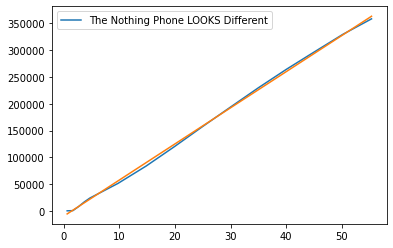

In [88]:
import matplotlib.pyplot as plt

for video_title, df in video_data.items():
    plt.plot(df.time_delta, df.views, label=video_title)
plt.plot(X, model.predict(X))
plt.legend()
plt.show()

In [89]:
conn.close()

In [90]:
model.score(X, y)

0.9991883945564636